In [1]:
import numpy as np
from scipy.misc import imread as im
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import confusion_matrix as CM
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score as recall
from sklearn.metrics import precision_score as precision
import os
from collections import Counter
%matplotlib inline

# Outlier Detection

In [21]:
## edit this to the result folder
folder = "/".join([os.getcwd(),"OutlierDetectionResult"])
print folder
lam_list = sorted(map(lambda x: float(x[3:]), filter(lambda x: 'lam' in x, os.listdir(folder))))
print lam_list

/home/czhou2/remoteJupyter/RobustAutoencoder/OutlierDetectionResult
[0.001, 0.0012, 0.0014, 0.0016, 0.0018, 0.002, 0.0022]


In [22]:
y = np.load(r"./data/y.npk")
stat = Counter(y)
print "number of majority:", stat[4]
print "number of outlier:", len(y) - stat[4]
print "outlier ratio:", (len(y) - stat[4])/float(stat[4])

number of majority: 4859
number of outlier: 265
outlier ratio: 0.0545379707759


In [23]:
def binary_error(value):
    if value == 0.0:
        return "m" # 'majority'
    else:
        return "o" #'outlier'
    
def binary_y(value):
    if value == 4:
        return "m"
    else:
        return "o"

bi_y = map(binary_y,y)
print Counter(bi_y)

Counter({'m': 4859, 'o': 265})


In [24]:
precisions=[]
lams=[]
recalls=[]
f1s = []
for i,lam in enumerate(lam_list):
    S = np.load(folder + "/" + "lam" + str(lam) + "/" + r"l21S.npk")    
    predictions = map(binary_error,np.linalg.norm(S,axis = 1))
    print "lambda:", lam
    print "precision",precision(bi_y,predictions,labels=["o","m"],pos_label="o")
    print "recall",recall(bi_y,predictions,labels=["o","m"],pos_label="o")
    print "f1",f1_score(bi_y,predictions,labels=["o","m"],pos_label="o")
    lams.append(lam)
    precisions.append(precision(bi_y,predictions,labels=["o","m"],pos_label="o"))
    recalls.append(recall(bi_y,predictions,labels=["o","m"],pos_label="o"))
    f1s.append(f1_score(bi_y,predictions,labels=["o","m"],pos_label="o"))
#     print CM(bi_y,predictions)
    print "------------"
print len(lams),len(recalls),len(f1s),len(precisions)

lambda: 0.001
precision 0.0517477055263
recall 1.0
f1 0.0984032677312
------------
lambda: 0.0012
precision 0.0529576338929
recall 1.0
f1 0.100588346935
------------
lambda: 0.0014
precision 0.0582456140351
recall 0.939622641509
f1 0.109691629956
------------
lambda: 0.0016
precision 0.0699617124956
recall 0.758490566038
f1 0.12810707457
------------
lambda: 0.0018
precision 0.089323098395
recall 0.483018867925
f1 0.150765606596
------------
lambda: 0.002
precision 0.153526970954
recall 0.279245283019
f1 0.19812583668
------------


IOError: [Errno 2] No such file or directory: '/home/czhou2/remoteJupyter/RobustAutoencoder/OutlierDetectionResult/lam0.0022/l21S.npk'

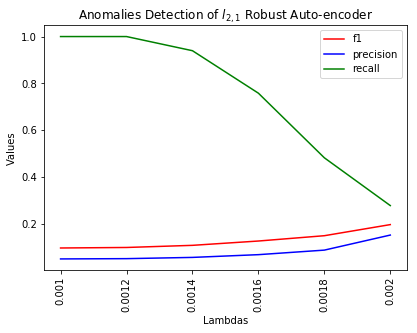

In [25]:
plt.figure(figsize=(6.5,4.5))
plt.xlabel("Lambdas")
plt.ylabel("Values")
plt.plot(range(len(lams)),f1s,color='r',label="f1")
plt.plot(range(len(lams)),precisions,color="b",label="precision")
plt.plot(range(len(lams)),recalls,color="g",label="recall")
plt.legend(["f1","precision","recall"],loc='best')
plt.xticks(range(len(lams)), lam_list,rotation='vertical')
plt.title("Anomalies Detection of $l_{2,1}$ Robust Auto-encoder")
plt.show()

## Plot the S and L

In [ ]:
%matplotlib inline
ncol = 3
folder_cor = folder + "/" ##+corruption_level_folder[-2]
fig,ax = plt.subplots(nrows=len(lam_list),ncols=ncol)
X = im(folder_cor + "/" +r"X.png")
for index in range(len(lam_list)):
    l21R = im(folder_cor + "/" + "lam" +lam_list[index]+ "/" + r"l21R.png")
    l21S = im(folder_cor + "/" + "lam" +lam_list[index] + "/" + r"l21S.png")
    
    ax[index][0].imshow(l21R,cmap = "gray")
    ax[index][1].imshow(l21S,cmap = "gray")
    ax[index][2].imshow(X,cmap = "gray")
    
    ax[index][0].set_title(lam_list[index]+r" L21 R")
    ax[index][1].set_title(lam_list[index]+r" L21 S")
    ax[index][2].set_title("X")
    ax[index][0].get_xaxis().set_visible(False)
    ax[index][0].get_yaxis().set_visible(False)
    ax[index][1].get_xaxis().set_visible(False)
    ax[index][1].get_yaxis().set_visible(False)
    ax[index][2].get_xaxis().set_visible(False)
    ax[index][2].get_yaxis().set_visible(False)
    
fig.set_size_inches(16,(len(lam_list))*3.5)
#fig.savefig(r"C:\Users\zc\Desktop\Result\Comparing.png",bbox_inches='tight')
plt.show()

# Benchmark Methods

## Isolation Forest

In [7]:
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
x = np.load(r"./data/data.npk")
print x.shape
def binary_y(value):
    if value == 4:
        return 1
    else:
        return -1
bi_y = map(binary_y,y)

(5124, 784)


In [8]:
fractions = np.arange(0.01,0.7,0.04)
y_preds = []
precisions=[]
fraction_list=[]
recalls=[]
f1s = []
for fraction in fractions:
    #model = EllipticEnvelope(contamination = fraction)
    model = IsolationForest(n_estimators=100,contamination=fraction,n_jobs=2)
    model.fit(x)
    y_pred = model.predict(x)
    y_preds.append(y_pred)
    
    p = precision(bi_y,y_pred,labels=[1,-1],pos_label=-1)
    r = recall(bi_y,y_pred,labels=[1,-1],pos_label=-1)
    f1 = f1_score(bi_y,y_pred,labels=[1,-1],pos_label=-1)
    print "fraction",fraction
    print "precision", p
    print "recall", r
    print "f1", f1
    print "------------"
    precisions.append(p)
    recalls.append(r)
    f1s.append(f1)

fraction 0.01
precision 0.557692307692
recall 0.109433962264
f1 0.182965299685
------------
fraction 0.05
precision 0.330739299611
recall 0.320754716981
f1 0.325670498084
------------
fraction 0.09
precision 0.287878787879
recall 0.501886792453
f1 0.365887207703
------------
fraction 0.13
precision 0.234234234234
recall 0.588679245283
f1 0.335123523093
------------
fraction 0.17
precision 0.195177956372
recall 0.641509433962
f1 0.299295774648
------------
fraction 0.21
precision 0.166356877323
recall 0.675471698113
f1 0.266964951529
------------
fraction 0.25
precision 0.154566744731
recall 0.747169811321
f1 0.256144890039
------------
fraction 0.29
precision 0.14064602961
recall 0.788679245283
f1 0.238720731011
------------
fraction 0.33
precision 0.13542282673
recall 0.864150943396
f1 0.234151329243
------------
fraction 0.37
precision 0.120253164557
recall 0.860377358491
f1 0.211013419713
------------
fraction 0.41
precision 0.110423607806
recall 0.875471698113
f1 0.196111580727
---

Max F1-score 0.365887207703


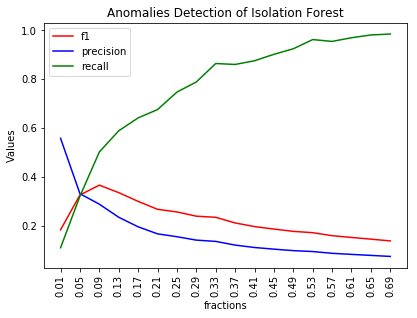

In [12]:
print "Max F1-score", np.max(f1s)
plt.close('all')
plt.figure(figsize=(6.5,4.5))
plt.xlabel("fractions")
plt.ylabel("Values")
plt.plot(range(len(fractions)),f1s,color='r',label="f1")
plt.plot(range(len(fractions)),precisions,color="b",label="precision")
plt.plot(range(len(fractions)),recalls,color="g",label="recall")
plt.legend(["f1","precision","recall"],loc='best')
plt.xticks(range(len(fractions)), fractions,rotation='vertical')
plt.title("Anomalies Detection of Isolation Forest")
plt.show()

## OneClass SVM

In [13]:
from sklearn.svm import OneClassSVM

In [14]:
fractions = np.arange(0.01,0.7,0.05)
y_preds = []
recalls=[]
f1s = []
precisions=[]
for fraction in fractions:
    model = OneClassSVM(nu=fraction)
    model.fit(x)
    y_pred = model.predict(x)
    y_preds.append(y_pred)
    p = precision(bi_y,y_pred,labels=[1,-1],pos_label=-1)
    r = recall(bi_y,y_pred,labels=[1,-1],pos_label=-1)
    f1 = f1_score(bi_y,y_pred,labels=[1,-1],pos_label=-1)
    print "fraction",fraction
    print "precision", p
    print "recall", r
    print "f1", f1
    print "------------"
    precisions.append(p)
    recalls.append(r)
    f1s.append(f1)

fraction 0.01
precision 0.5625
recall 0.101886792453
f1 0.172523961661
------------
fraction 0.06
precision 0.419141914191
recall 0.479245283019
f1 0.447183098592
------------
fraction 0.11
precision 0.3074204947
recall 0.656603773585
f1 0.418772563177
------------
fraction 0.16
precision 0.250608272506
recall 0.777358490566
f1 0.379024839006
------------
fraction 0.21
precision 0.211502782931
recall 0.860377358491
f1 0.339538346984
------------
fraction 0.26
precision 0.178544636159
recall 0.898113207547
f1 0.297872340426
------------
fraction 0.31
precision 0.152926368785
recall 0.916981132075
f1 0.26213592233
------------
fraction 0.36
precision 0.13557483731
recall 0.943396226415
f1 0.237079184448
------------
fraction 0.41
precision 0.121197718631
recall 0.962264150943
f1 0.21528070916
------------
fraction 0.46
precision 0.108566581849
recall 0.966037735849
f1 0.195196340069
------------
fraction 0.51
precision 0.0983167559296
recall 0.969811320755
f1 0.178534213268
------------


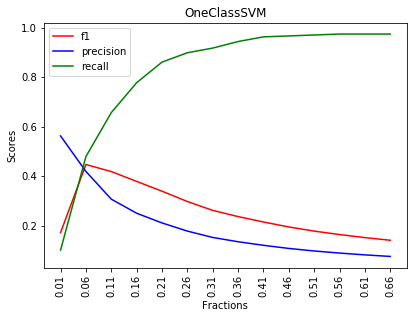

In [15]:
print "Max F1-score", np.max(f1s)
plt.figure(figsize=(6.5,4.5))
plt.xlabel("Fractions")
plt.ylabel("Scores")
plt.plot(range(len(fractions)),f1s,color='r',label="f1")
plt.plot(range(len(fractions)),precisions,color="b",label="precision")
plt.plot(range(len(fractions)),recalls,color="g",label="recall")
plt.legend(["f1","precision","recall"],loc='best')
plt.xticks(range(len(fractions)), fractions,rotation='vertical')
plt.title("OneClassSVM")
plt.show()